In [8]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft        
import ZonalStatsFunctions as zsf
import datetime as dt

In [2]:
client = Client(n_workers = 12)

In [3]:
session = cc.database.create_session()

# Comparing different resolutions

In [44]:
import ZonalStatsFunctions as zsf
# help(cc.querying.getvar)

SO_SST_1deg = cc.querying.getvar(expt = '1deg_jra55v13_iaf_spinup1_B1', variable = 'sst_m', session = session, start_time = '2008-01', end_time = '2008-02', frequency = '1 monthly')
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
SO_SST_1deg.coords['ni'] = geolon_t['xt_ocean'].values
SO_SST_1deg.coords['nj'] = geolon_t['yt_ocean'].values
# #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
SO_SST_1deg = SO_SST_1deg.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
SO_SST_1deg = SO_SST_1deg[0].sel(yt_ocean = slice(-90, -45))

SO_SST_025deg = zsf.getACCESSdata('surface_temp', '2008-01', '2008-02', freq = '1 monthly', ses = session, exp = '025deg_jra55v13_iaf_gmredi6')
SO_SST_010deg = zsf.getACCESSdata('surface_temp', '2008-01', '2008-02', freq = '1 monthly', ses = session, exp = '01deg_jra55v140_iaf_cycle2')

# SO_SSTc = zsf.corrlong(SO_SST)
# SO_SSTc[0].plot()

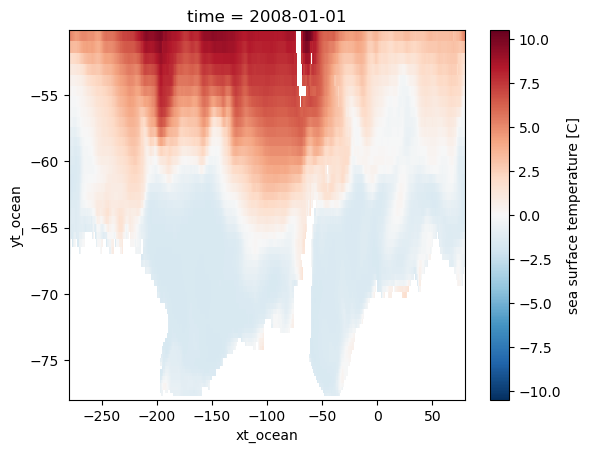

In [42]:
SO_SST_1deg.plot()

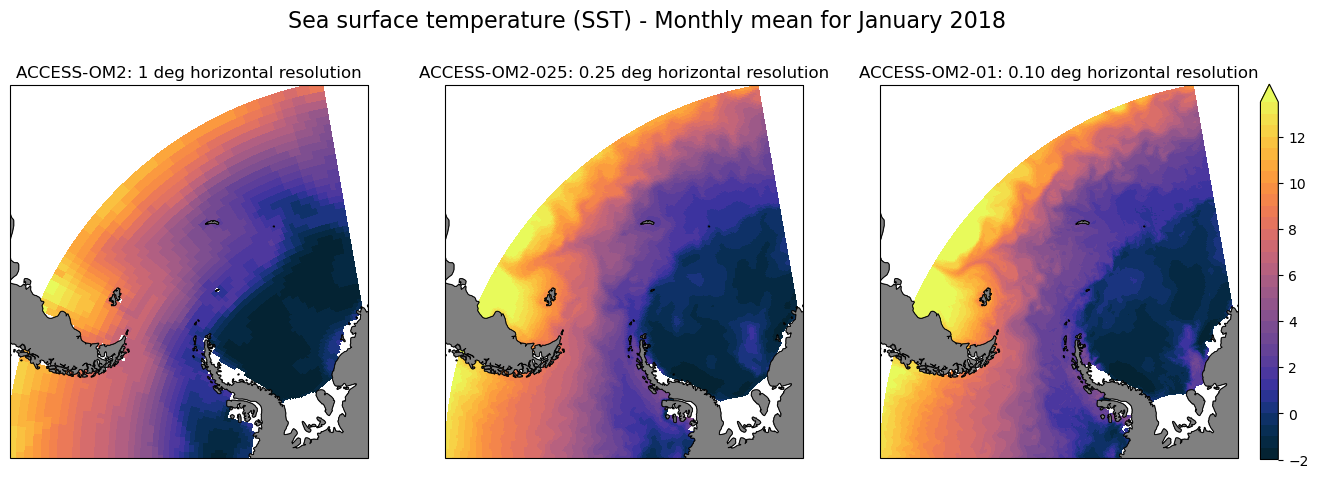

In [72]:
import matplotlib.gridspec as gridspec
projection = ccrs.SouthPolarStereo()
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)
fig = plt.figure(figsize = (17, 15))

levels = np.arange(-2, 14, 0.5)

gs = gridspec.GridSpec(nrows = 1, ncols = 3, width_ratios = [0.8, 0.8, 1])

deg1 = fig.add_subplot(gs[0, 0], projection = projection)
p_deg1 = (SO_SST_1deg).sel(xt_ocean = slice(-90, -10)).plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = deg1,
                                                                             cmap = cm.cm.thermal, add_colorbar = False, levels = levels,
                                                                             transform = ccrs.PlateCarree())
deg1.set_title('ACCESS-OM2: 1 deg horizontal resolution')

deg025 = fig.add_subplot(gs[0, 1], projection = projection)
p_deg025 = (SO_SST_025deg[0]-273.15).sel(xt_ocean= slice(-90,-10)).plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = deg025,
              #Setting color palette and contour levels
              cmap = cm.cm.thermal, add_colorbar = False, levels = levels,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
deg025.set_title('ACCESS-OM2-025: 0.25 deg horizontal resolution')

deg010 = fig.add_subplot(gs[0, 2], projection = projection)
p_deg010 = (SO_SST_010deg[3]-273.15).sel(xt_ocean= slice(-90,-10)).plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = deg010,
              #Setting color palette and contour levels
              cmap = cm.cm.thermal, add_colorbar = False, levels = levels,
              #Remove colourbar to allow for further manipulation
              transform = ccrs.PlateCarree())
deg010.set_title('ACCESS-OM2-01: 0.10 deg horizontal resolution')
fig.colorbar(p_deg010, shrink = 0.325)

for ax in [deg1, deg025, deg010]:
    #Remove x and y axes labels
    ax.set_ylabel("")
    ax.set_xlabel("")
    #Coastlines to appear
    ax.coastlines(resolution = '50m')
    #Add feature loaded at the beginning of this section
    ax.add_feature(land_50m)
    #Set the extent of maps
    ax.set_extent([-90, -10, -75, -45], crs = ccrs.PlateCarree())

plt.suptitle('Sea surface temperature (SST) - Monthly mean for January 2018', y = 0.67, fontsize = 16)
plt.savefig('Example_SST_1_025_010deg.png', dpi = 300)

# expvar = cc.querying.get_variables(session, '1deg_jra55v13_iaf_spinup1_B1')#'1deg_jra55v13_iaf')
# expvar[expvar["name"].str.lower().str.match(".*temp.*")] 
# # from tqdm import tqdm_notebook
# # tqdm_notebook(expts, leave=False, desc="experiments")
# help(tqdm_notebook)

# Sea Ice Plots

In [5]:
#Defining experiment
exp = "01deg_jra55v140_iaf_cycle2"
varInt = "aice_m" #sea ice concentration
freq = '1 monthly'
#Accessing corrected longitude data to update geographical coordinates in the array of interest
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n = -1)

In [40]:
SO = cc.querying.getvar(exp, varInt, session, frequency = freq, start_time = '2018-01', end_time = '2018-03')
SO.coords['ni'] = geolon_t['xt_ocean'].values
SO.coords['nj'] = geolon_t['yt_ocean'].values
SO = SO.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
SO = SO.sel(yt_ocean = slice(-90, -45))
SO

<xarray.DataArray 'aice_m' (time: 3, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(3, 740, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-02-01 2018-03-01
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 3, d2: 2)>\ndask.a...

In [79]:
# SO['time'] = SO.time.to_pandas() - dt.timedelta(hours = 12)
SO.time

<xarray.DataArray 'time' (time: 3)>
array(['2017-12-31T12:00:00.000000000', '2018-01-31T12:00:00.000000000',
       '2018-02-28T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-12-31T12:00:00 ... 2018-02-28T12:00:00

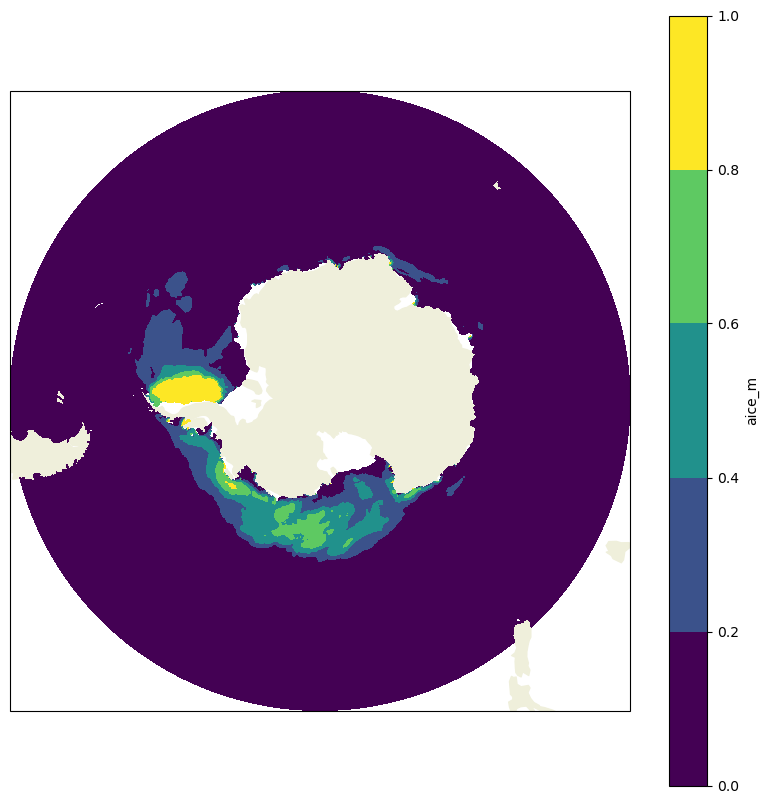

In [75]:
#Define projection to polar
projection = ccrs.SouthPolarStereo(central_longitude = 30)

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Start plot
fig = plt.figure(figsize = (10, 10))

#Add figure
p1 = fig.add_subplot(1, 1, 1, projection = projection)

SO.mean('time').plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = p1, transform = ccrs.PlateCarree())

p1.add_feature(cft.LAND)

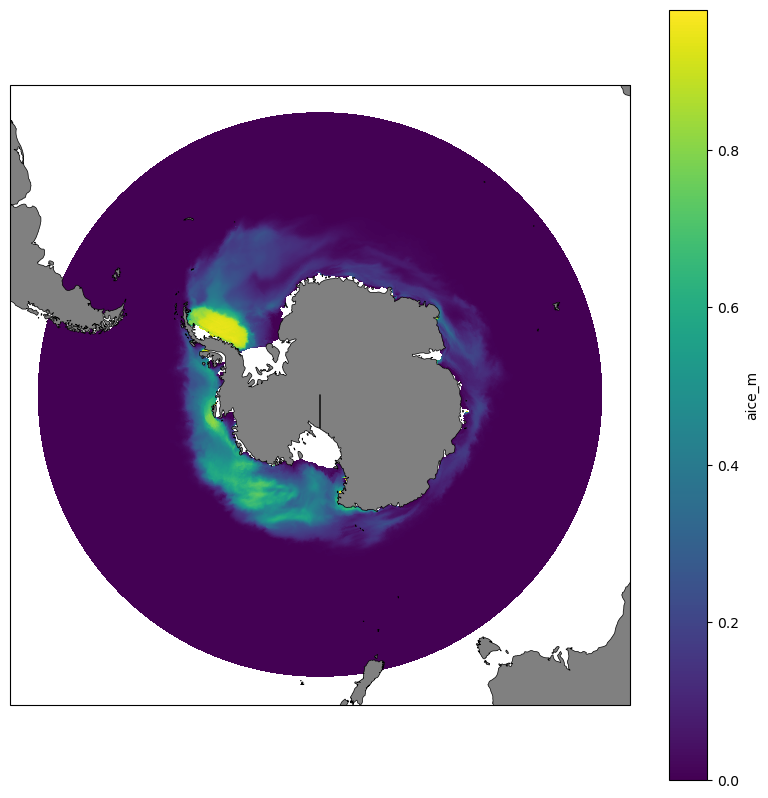

In [73]:
#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Start plot
fig = plt.figure(figsize = (10, 10))

#Add figure
p1 = fig.add_subplot(1, 1, 1, projection = projection)

SO.mean('time').plot(x = 'xt_ocean', y = 'yt_ocean', ax = p1, transform = ccrs.PlateCarree())

p1.add_feature(land_50m)

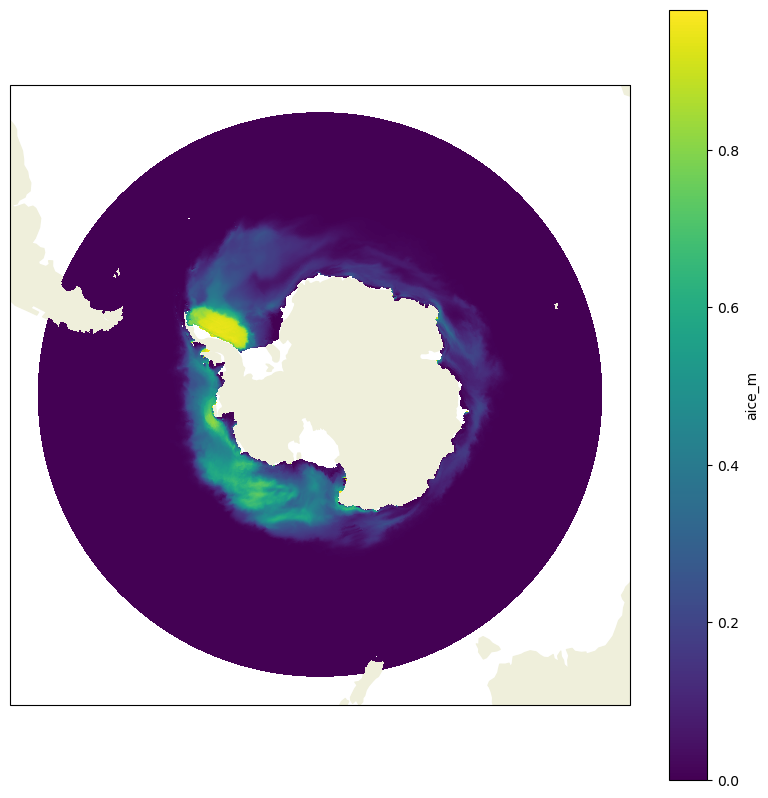

In [74]:
#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Start plot
fig = plt.figure(figsize = (10, 10))

#Add figure
p1 = fig.add_subplot(1, 1, 1, projection = projection)

SO.mean('time').plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = p1, transform = ccrs.PlateCarree())

p1.add_feature(cft.LAND)

# Plotting MEASO regions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Loading shapefiles for MEASO regions
Temperate areas are excluded from the graph as they will not be used in any analyses

In [2]:
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')
MEASO = MEASO.query('zone != "Temperate"')
MEASO

,name,sector,zone,fill,Label_Zone,geometry
0,WPA,WestPacific,Antarctic,#016074FF,0.0,"POLYGON ((0.000 -2801203.162, -9640.306 -28011..."
1,WPA,WestPacific,Antarctic,#BCECFEFF,0.0,"POLYGON ((0.000 -2801203.162, -9640.306 -28011..."
2,WPS,WestPacific,Subantarctic,#1094AFFF,0.0,"POLYGON ((-2250033.244 -1575490.239, -2244520...."
3,WPN,West Pacific,Northern,#054e70FF,1.0,"POLYGON ((-4421564.387 -3096012.714, -4405068...."
5,EPA,EastPacific,Antarctic,#FFFFFFFF,0.0,"POLYGON ((-457314.899 -320215.339, -475594.187..."
6,EPS,EastPacific,Subantarctic,#5F9EA0FF,0.0,"POLYGON ((-2250033.244 -1575490.239, -2267455...."
7,EPN,East Pacific,Northern,#4B7D7EFF,1.0,"POLYGON ((-2992182.948 -2095149.056, -3009661...."
9,AOA,Atlantic,Antarctic,#BCECFEFF,0.0,"POLYGON ((-2891646.910 1737476.753, -2906527.1..."
11,AOS,Atlantic,Subantarctic,#1094AFFF,0.0,"POLYGON ((1842391.575 3191115.815, 1832255.865..."
12,AON,Atlantic,Northern,#054e70FF,1.0,"POLYGON ((2613012.979 4525871.241, 2602872.922..."


## Loading shapefile of Antarctica
Polygon obtained from the BAS Antarctic Digital Database. Recommended citation: "Gerrish, L., Fretwell, P., & Cooper, P. (2021). Medium resolution vector polygons of the Antarctic coastline (7.4) [Data set]. UK Polar Data Centre, Natural Environment Research Council, UK Research & Innovation. https://doi.org/10.5285/747e63e-9d93-49c2-bafc-cf3d3f8e5afa".  
For graphs a shorter citation is recommended: 'data from the SCAR Antarctic Digital Database, accessed \[year\]'.

In [22]:
Antarctica = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/CoastlineAntarctica/add_coastline_medium_res_polygon_v7_4.shp')

#Adding a new column to set the colours shown in the map
Antarctica['color'] = "#dfdfdf"
Antarctica['color'] = np.where(Antarctica['surface'].str.contains('ice'), "#ffffff", Antarctica['color'])
Antarctica

,Id,surface,geometry,color
0,0,land,"POLYGON ((772696.680 -2471038.412, 772832.992 ...",#dfdfdf
1,0,land,"POLYGON ((774734.242 -2464704.100, 775046.430 ...",#dfdfdf
2,0,land,"POLYGON ((765883.305 -2464690.037, 766248.930 ...",#dfdfdf
3,0,land,"POLYGON ((732912.367 -2435421.756, 733393.305 ...",#dfdfdf
4,0,land,"POLYGON ((729697.680 -2433824.256, 730009.867 ...",#dfdfdf
...,...,...,...,...
2275,0,land,"POLYGON ((-2277980.942 2307693.324, -2278035.9...",#dfdfdf
2276,0,land,"POLYGON ((-2298166.694 2311139.654, -2298094.4...",#dfdfdf
2277,0,land,"POLYGON ((-2299743.034 2312840.278, -2299697.7...",#dfdfdf
2278,0,land,"POLYGON ((-2276162.698 2319646.459, -2276383.3...",#dfdfdf


## Loading shapefile of the world
This shapefile was obtained from the GADM database [www.gadm.org], version 3.4, April 2018.

In [37]:
world = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/WorldCountries/gadm36_0.shp')

#Changing CRS for world shapefile to match that of Antarctica and MEASO regions before plotting
world = world.to_crs(Antarctica.crs)

## Putting MEASO regions map together

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


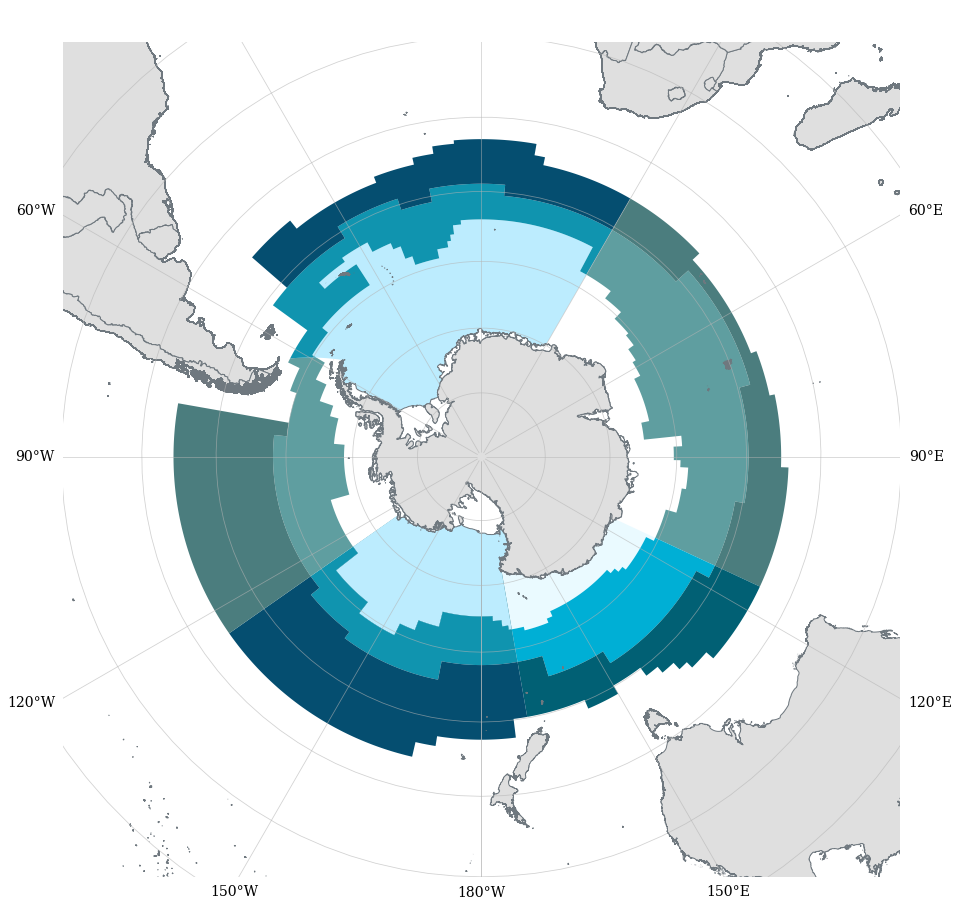

In [48]:
#Using the correct projection for the map to show Antarctica
projection = ccrs.SouthPolarStereo()

#Initialise plot
fig = plt.figure(figsize = (15, 20))
#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Add a figure
ax = fig.add_subplot(projection = projection)

#Plot MEASO regions using the colors included under the fill column
MEASO.plot(ax = ax, color = MEASO['fill'])

#Plot the world map
world.plot(ax = ax, color = "#dfdfdf", edgecolor = "#6f787f")

#Finally plot the Antarctica shapefile using the colors specified in the color column
Antarctica.plot(ax = ax, color = Antarctica['color'], edgecolor = "#6f787f")

#Do not include any titles or axes labels
ax.set_title('')
ax.set_ylabel("")
ax.set_xlabel("")

#Set the extent of the map
ax.set_extent([-180, 180, -90, -30], crs = ccrs.PlateCarree())

#Draw gridlines
gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
#Locate longitude ticks - Set to every 30 deg
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
#Give longitude labels the correct format for longitudes
gl.xformatter = LONGITUDE_FORMATTER
#Set rotation of longitude labels to zero
gl.xlabel_style = {'rotation': 0}
#Set latitude labels to be transparent
gl.ylabel_style = {'alpha': 0}
#Add space between axis ticks and labels for x and y axes
gl.xpadding = 9
gl.ypadding = 9
gl.xlabels_left = False
gl.xlabels_right = True
gl.xlabels_top = False

#Remove the outside frame and ticklines of the figure
[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_xticklines()]
[t.set_visible(False) for t in ax.get_yticklines()]

#Saving final figure
plt.savefig('/g/data/v45/la6889/Figures/Maps/SO_Antarctica_MEASO.png', dpi = 300)

# Trend calculation

In [5]:
import ZonalStatsFunctions as zsf
#Location of files with seasonal weighted means
folder = r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means/'
comb_Ind = zsf.stackData(folder, 'Indian')

In [13]:
obs = np.arange(0,len(comb_Ind))
obs

In [18]:
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression().fit(obs, comb_Ind)
# reg

X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
X
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
y
reg = LinearRegression().fit(X, y)
reg.score(X, y)

1.0